<a href="https://colab.research.google.com/github/temple17/hands-on-ml-practice/blob/main/Chapter3_Classification(p_130~).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Download MNIST dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl

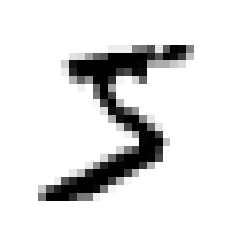

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

In [11]:
# Training a Binary Classifier

# 5-detector

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [12]:
# Stochastic Gradient Descent (SGD)

from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
# Performance Measures

# Measuring Accuracy Using Cross-validation

# Implementing Cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [19]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3,scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [20]:
"""This is just because only about 10% of the images are 5s,
soo if you always guess that an image is not a 5, you will be right about 90% 
of the time.
This demonstrates why accuracy is generally not the preferred performance measure for classifier
"""

'This is just because only about 10% of the images are 5s,\nsoo if you always guess that an image is not a 5, you will be right about 90% \nof the time.\nThis demonstrates why accuracy is generally not the preferred performance measure for classifier\n'

In [21]:
# Confusion Matrix

# A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

# The general idea is to count the number of times instances of class A are classified as class B.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [22]:
# Instead of returning the evaluation scores, it returns the predictions made on each test fold

# This means that you get a clean prediction for each instance in the training set

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
# Each row in a confusion matrix represents an actual class,
# while each column represents a predicted class

# The first row of this matrix considers non-5-images(negative class) : 53,057
# of them were correctly classified as non-5s(true negative)

# while the remaining 687 were wrongly classified as 5s (false positives)

# The second row considers the images of 5s (the positive class) : 1891 were
# wrongly classified as non-5s (false negative), while the remaining 3530
# were correctly classified as 5s (true positives)

"""A perfect classifier would have only true positives and true negatives, 
so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right)"""

'A perfect classifier would have only true positives and true negatives, \nso its confusion matrix would have nonzero values only on its main diagonal\n(top left to bottom right)'

In [24]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [25]:
"""Use TPR (true positive rate)
this is the ratio of positive instances that are correctly detected by the classifier."""

'Use TPR (true positive rate)\nthis is the ratio of positive instances that are correctly detected by the classifier.'

In [26]:
# Precision/Recall trade-off

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
"""How to decide which threshold to use?
First, use the cross_val_predict() function to get the scores of all instances 
in the training set"""

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = 'decision_function')

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    # highlight the threshold and add the legend, axis label, and grid


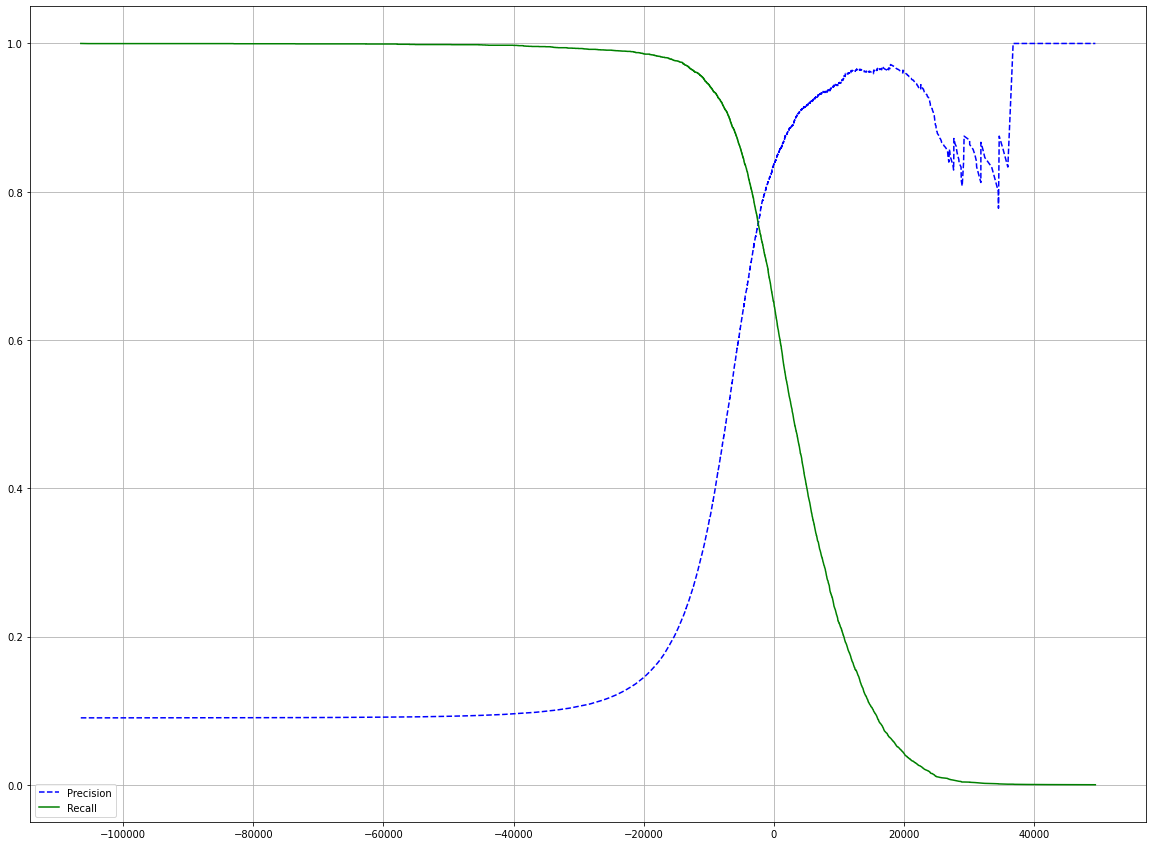

In [46]:
plt.figure(figsize = (20,15))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.grid()

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [48]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [49]:
precision_score(y_train_5, y_train_pred_90)

NameError: ignored

In [43]:
recall_score(y_train_5, y_train_pred_90)

NameError: ignored